In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import torch
import torch.nn as nn

from matplotlib import pyplot as plt

from nltk.corpus import stopwords

from sklearn import metrics

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from torch.utils.data import DataLoader, Dataset

from typing import Any

In [2]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/twitter_training.csv", names=["TweetId","Entity","Sentiment","TweetText"])
test = pd.read_csv("/content/drive/MyDrive/twitter_sentiment/twitter_validation.csv", names=["TweetId","Entity","Sentiment","TweetText"])

In [5]:
train

,TweetId,Entity,Sentiment,TweetText
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [6]:
train['Entity'].value_counts()

TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)               

In [7]:
train['Sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

In [9]:
train.describe()

,TweetId
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   TweetText  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
traindf = train[["TweetText","Sentiment"]]
testdf=test[["TweetText","Sentiment"]]

In [11]:
testdf

,TweetText,Sentiment
0,I mentioned on Facebook that I was struggling ...,Irrelevant
1,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
2,@Microsoft Why do I pay for WORD when it funct...,Negative
3,"CSGO matchmaking is so full of closet hacking,...",Negative
4,Now the President is slapping Americans in the...,Neutral
...,...,...
995,⭐️ Toronto is the arts and culture capital of ...,Irrelevant
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
997,Today sucked so it’s time to drink wine n play...,Positive
998,Bought a fraction of Microsoft today. Small wins.,Positive


In [12]:
traindf['TweetText'].unique()

array(['im getting on borderlands and i will murder you all ,',
       'I am coming to the borders and I will kill you all,',
       'im getting on borderlands and i will kill you all,', ...,
       'Just realized the windows partition of my Mac is now 6 years behind on Nvidia drivers and I have no idea how he didn’t notice',
       'Just realized between the windows partition of my Mac is like being 6 years behind on Nvidia drivers and cars I have no fucking idea how I ever didn ’ t notice',
       'Just like the windows partition of my Mac is like 6 years behind on its drivers So you have no idea how I didn’t notice'],
      dtype=object)

In [13]:
traindf= traindf.drop_duplicates()
testdf= testdf.drop_duplicates()

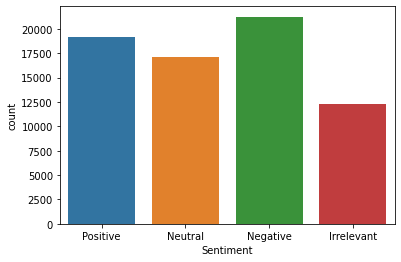

In [ ]:
sns.countplot(x="Sentiment",data=traindf)

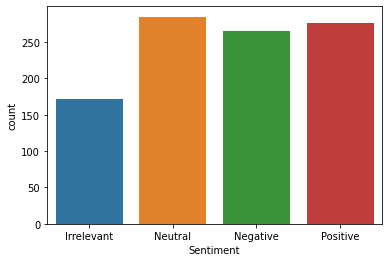

In [ ]:
sns.countplot(x="Sentiment",data=testdf)

In [ ]:
label = []

for i in traindf["Sentiment"]:
    if i == "Positive":
        label.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        label.append(0)
    else:
        label.append(2)
traindf["label"] = label

In [ ]:
label = []

for i in testdf["Sentiment"]:
    if i == "Positive":
        label.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        label.append(0)
    else:
        label.append(2)
testdf["label"] = label

In [ ]:
traindf['label'].value_counts()

 0    29396
-1    21238
 1    19139
Name: label, dtype: int64

In [ ]:
traindf.dtypes

TweetText    object
Sentiment    object
label         int64
dtype: object

In [ ]:
stop_words = set(stopwords.words("english"))

In [ ]:
traindf["Text"] = traindf["TweetText"].str.replace("\d","")
testdf["Text"] = testdf["TweetText"].str.replace("\d","")

In [ ]:
def cleaner(data):
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [ ]:
traindf["TweetText"] = traindf["TweetText"].apply(cleaner)
testdf["TweetText"] = testdf["TweetText"].apply(cleaner)


In [ ]:
testdf["TweetText"]

0      mention facebook struggl motiv go run day tran...
1      bbc news amazon bo jeff bezo reject claim comp...
2      microsoft pay word function poorli samsungu ch...
3           csgo matchmak full closet hack truli aw game
4      presid slap american face realli commit unlaw ...
                             ...                        
995    toronto art cultur capit canada wonder want st...
996    actual good move tot bring viewer one peopl go...
997    today suck time drink wine n play borderland s...
998            bought fraction microsoft today small win
999    johnson johnson stop sell talc babi powder can...
Name: TweetText, Length: 999, dtype: object

In [ ]:
traindf["TweetText"]=traindf["TweetText"].str.replace("im","")
testdf["TweetText"]=testdf["TweetText"].str.replace("im","")


In [ ]:
rare_words_train = pd.Series(" ".join(traindf["TweetText"]).split()).value_counts()


In [ ]:
rare_words_train

game        10775
play         6820
get          5567
like         5143
go           4216
            ...  
игорь           1
comey           1
scotsman        1
броке           1
bfvu            1
Length: 19664, dtype: int64

In [ ]:
rare_words_train = rare_words_train[rare_words_train <= 2]

In [ ]:
traindf["TweetText"] = traindf["TweetText"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words_train.index]))

In [ ]:
rare_words_test = pd.Series(" ".join(testdf["TweetText"]).split()).value_counts()
rare_words_test = rare_words_test[rare_words_test <= 2]
testdf["TweetText"] = testdf["TweetText"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words_test.index]))

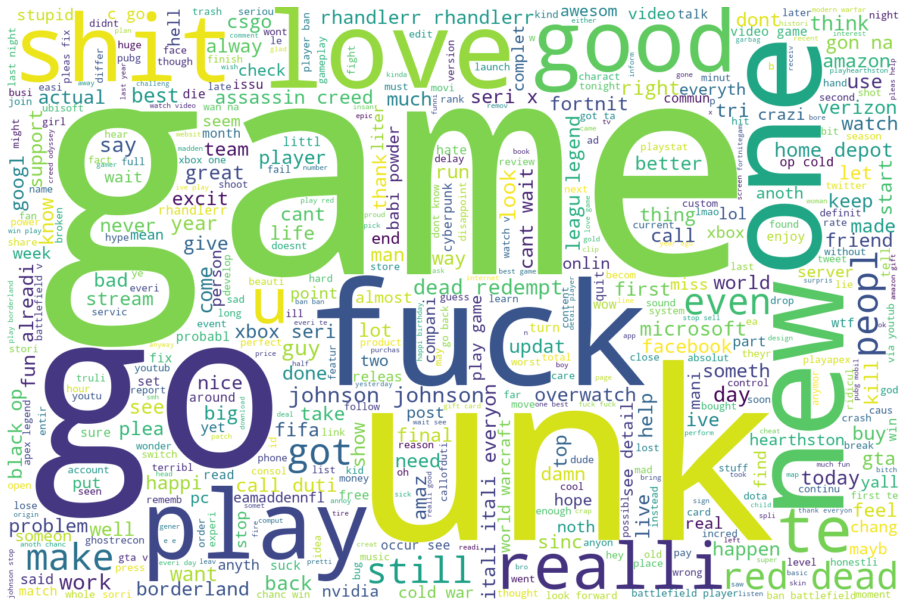

In [ ]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="white",max_words=500, width=1500, height=1000).generate(' '.join(traindf['TweetText']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [ ]:
trainX = traindf["TweetText"]
y_train = traindf["label"]
testX = testdf["TweetText"]
y_test = testdf["label"]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
len(trainX)

69773

In [ ]:
trainX.shape

(69773,)

In [ ]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(trainX)
X_test_count = vt.transform(testX)

In [ ]:
X_train_count[1]

<1x13355 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_count=X_train_count.toarray()
X_train_count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_train_count.shape

(69773, 13355)

In [ ]:
sp=X_train_count.shape

In [ ]:
import tensorflow as tf

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=69773,
 output_mode='int',
 output_sequence_length=128)

In [ ]:
vectorize_layer.adapt(trainX)

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU ,Bidirectional, CuDNNLSTM ,BatchNormalization ,Flatten

In [ ]:
model=Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
#model.add(Embedding(input_dim=69775,output_dim=128,input_length=13355))
#model.add(LSTM(64, return_sequences=True, activation="sigmoid"))
#model.add(Bidirectional(LSTM(64, return_sequences=True, activation="relu")))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import time
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:

# try using different optimizers and different optimizer configs
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath="model_with_pca.tf", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('training_set_iranalysis1.csv',separator=',', append=False)
h=model.fit(trainX, y_train, epochs=5, validation_data=(testX, y_test),callbacks=[checkpointer,csv_logger])

Epoch 1/5
2179/2181 [============================>.] - ETA: 0s - loss: 6.3349 - accuracy: 0.3572
Epoch 1: val_accuracy improved from -inf to 0.35836, saving model to model_with_pca.tf
2181/2181 [==============================] - 7s 3ms/step - loss: 6.3338 - accuracy: 0.3572 - val_loss: 1.6712 - val_accuracy: 0.3584
Epoch 2/5
2166/2181 [============================>.] - ETA: 0s - loss: 6.5128 - accuracy: 0.3562
Epoch 2: val_accuracy did not improve from 0.35836
2181/2181 [==============================] - 5s 2ms/step - loss: 6.5046 - accuracy: 0.3563 - val_loss: 1.9570 - val_accuracy: 0.3273
Epoch 3/5
2160/2181 [============================>.] - ETA: 0s - loss: 6.3959 - accuracy: 0.3577
Epoch 3: val_accuracy did not improve from 0.35836
2181/2181 [==============================] - 5s 2ms/step - loss: 6.3897 - accuracy: 0.3578 - val_loss: 2.3331 - val_accuracy: 0.2813
Epoch 4/5
2167/2181 [============================>.] - ETA: 0s - loss: 6.3450 - accuracy: 0.3605
Epoch 4: val_accuracy di

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train_count,y_train)
knn_pred = knn_model.predict(X_test_count)
knn_train_pred = knn_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.76      0.88      0.82       266
           0       0.90      0.80      0.84       457
           1       0.80      0.83      0.81       276

    accuracy                           0.83       999
   macro avg       0.82      0.84      0.83       999
weighted avg       0.84      0.83      0.83       999

X Train
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94     21238
           0       0.94      0.95      0.94     29396
           1       0.94      0.92      0.93     19139

    accuracy                           0.94     69773
   macro avg       0.94      0.94      0.94     69773
weighted avg       0.94      0.94      0.94     69773



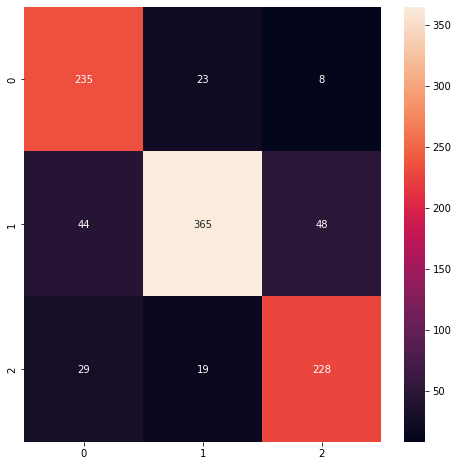

In [ ]:
print("X Test")
print(classification_report(y_test,knn_pred))
print("X Train")
print(classification_report(y_train,knn_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True,fmt = "d")

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve


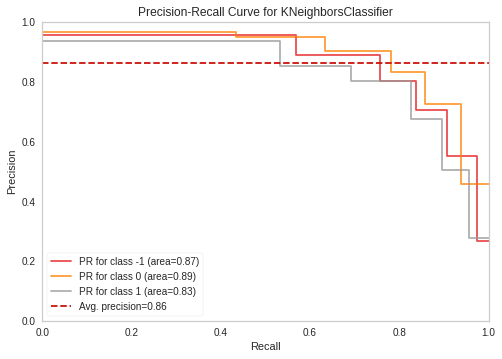

In [ ]:
viz = PrecisionRecallCurve(KNeighborsClassifier(),
                           classes=knn_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [ ]:
from sklearn.svm import SVC
svc_model = SVC().fit(X_train_count,y_train)
svc_pred = svc_model.predict(X_test_count)
svc_train_pred = svc_model.predict(X_train_count)

In [ ]:
print("X Test")
print(classification_report(y_test,svc_pred))
print("X Train")
print(classification_report(y_train,svc_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,svc_pred),annot = True,fmt = "d")